In [2]:
%load_ext rpy2.ipython

In [3]:
%%R

#install.packages("tibble")
#install.packages("dplyr")
#install.packages(ggplot2)
#install.packages("caret")
#install.packages("glmnet")

library(tibble)
library(dplyr)
library(ggplot2)
library(caret)
library(pROC)
library(ROSE)
library(glmnet)

# Loading custom functions "CalculatedFieldSubroutines.R" 
source("CalculatedFieldSubroutines.R")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loaded ROSE 0.0-4

Loading required package: Matrix
Loaded glmnet 4.1-8
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [4]:
%%R

binary_driving_mode <- function (df_chassis) {
    result <- ifelse(df_chassis$drivingMode == "COMPLETE_AUTO_DRIVE", 1, 0)

    return(result)
}


merge_chassis_pose <- function (df_chassis, df_pose) {
    
    
    df_chassis <- df_chassis[order(df_chassis$time), ]
    df_pose <- df_pose[order(df_pose$time), ]
    
    #make sure data is sorted by time fist

    chassis_time_arr <- df_chassis$time
    pose_time_arr <- df_pose$time

    matched_vector <- c()

    for (chassis_time in chassis_time_arr) {
        abs_time_diff_arr <- abs(pose_time_arr - chassis_time)

        min_index <-  which(abs_time_diff_arr == min(abs_time_diff_arr))
        
        matched_vector <-  c(matched_vector, pose_time_arr[min_index])
    }



    #df_chassis$matched <- df_pose$time[which(abs(pose_time_arr - df_chassis$time) == min(abs(pose_time_arr - df_chassis$time)))]
    df_chassis$matched <-  matched_vector
    df_pose$matched <-  df_pose$time


    return (list(df_chassis = df_chassis, df_pose = df_pose))


}

latlongStdDev <- function(df_pose){
    x <- df_pose["latitudeStdDev"]
    y <- df_pose["longitudeStdDev"]
    r <- sqrt(x^2 + y^2)

    return(r)

}

In [5]:
%%R
# Defining GMIDs for Red Routes
# Am creating a list of GMIDs for processing
red_route_gmIDs  <- c(
     "2f95c748-f009-11ee-b966-fb353e7798cd",
  "65cfbfd6-f396-11ee-bb4e-fb353e7798cd",
  "f711e68e-f0e1-11ee-ba1f-fb353e7798cd",
  "171c50bc-f106-11ee-ba42-fb353e7798cd",
  "6d2ea45a-c839-11ee-a7fc-dd032dba19e8",
  "05c7c824-cab8-11ee-aa4d-1d66adf2f0c7",
  "96f7a614-f549-11ee-8afa-cb629b0d53e6",
  "cf831f42-f353-11ee-bb4e-fb353e7798cd",
  "f0eebb6a-f0dc-11ee-ba1e-fb353e7798cd",
  "9798fe24-f143-11ee-ba78-fb353e7798cd",
  "ce6465b6-f51b-11ee-8afa-cb629b0d53e6",
  "3d2d29ec-ef95-11ee-b966-fb353e7798cd",
  "d3698592-ef9d-11ee-b966-fb353e7798cd",
  "853ef120-cad3-11ee-909c-e1dc60cf66f9",
  "be857244-efc0-11ee-b966-fb353e7798cd",
  "f43b6a70-f01e-11ee-b966-fb353e7798cd",
  "fcc6fcd2-f013-11ee-b966-fb353e7798cd",
  "e7b934a8-ef1a-11ee-9385-ef789ffde1d3",
  "61b12e7a-f234-11ee-bb33-fb353e7798cd",
  "de933de8-f112-11ee-ba4d-fb353e7798cd",
  "8dbbbf1c-f0ef-11ee-ba29-fb353e7798cd",
  "fe973c9c-f53c-11ee-8afa-cb629b0d53e6",
  "ecebb942-f162-11ee-ba97-fb353e7798cd",
  "f755cf60-f132-11ee-ba6d-fb353e7798cd",
  "d24820c8-f197-11ee-babe-fb353e7798cd",
  "dd72fdec-f0cf-11ee-ba0d-fb353e7798cd",
  "286e019a-f204-11ee-bb07-fb353e7798cd",
  "41b67a28-f52f-11ee-8afa-cb629b0d53e6",
  "c0555ef0-f50f-11ee-8afa-cb629b0d53e6",
  "72a03d4a-efe9-11ee-b966-fb353e7798cd",
  "457dc5ee-f02a-11ee-b966-fb353e7798cd",
  "3151e9e2-eff3-11ee-b966-fb353e7798cd",
  "c25271be-f3a4-11ee-bb4e-fb353e7798cd",
  "2a61b8a8-f528-11ee-8afa-cb629b0d53e6",
  "01e65360-efd4-11ee-b966-fb353e7798cd",
  "1bbbfbae-c839-11ee-a7fc-dd032dba19e8",
  "f41cbd44-eff8-11ee-b966-fb353e7798cd",
  "aa5dbcd2-ef10-11ee-9385-ef789ffde1d3",
  "84d96f18-f214-11ee-bb13-fb353e7798cd",
  "94c53148-eeed-11ee-9385-ef789ffde1d3",
  "88a68dd8-eef9-11ee-9385-ef789ffde1d3",
  "85b6e70e-ef7a-11ee-b966-fb353e7798cd",
  "1b6aca0e-efdf-11ee-b966-fb353e7798cd",
  "8fa6fe80-c869-11ee-a7fc-dd032dba19e8",
  "51ef6da6-ca9f-11ee-909c-e1dc60cf66f9",
  "9189a2a8-f121-11ee-ba5b-fb353e7798cd",
  "8347b862-efad-11ee-b966-fb353e7798cd",
  "88dd6fbe-f224-11ee-bb21-fb353e7798cd",
  "817d6848-efb6-11ee-b966-fb353e7798cd",
  "fc211bb2-efca-11ee-b966-fb353e7798cd",
  "c338788a-d324-11ee-b437-336917683bb8",
  "b82476fe-f1f3-11ee-baff-fb353e7798cd",
  "7cbd932e-f244-11ee-bb3f-fb353e7798cd",
  "2462c9d0-eecd-11ee-9385-ef789ffde1d3",
  "3344a3c0-f502-11ee-8afa-cb629b0d53e6",
  "d21965e6-f0fa-11ee-ba37-fb353e7798cd",
  "c9c6856c-d33c-11ee-b437-336917683bb8",
  "d12cd1c4-caec-11ee-909c-e1dc60cf66f9",
  "43a1a35e-f362-11ee-bb4e-fb353e7798cd",
  "fd1ab258-efa7-11ee-b966-fb353e7798cd",
  "8437f77a-cab7-11ee-909c-e1dc60cf66f9",
  "211bdb36-f0da-11ee-ba1b-fb353e7798cd",
  "868de15e-f3b3-11ee-bb4e-fb353e7798cd",
  "35518ec4-f153-11ee-ba88-fb353e7798cd",
  "622bd2e8-f0e4-11ee-ba1f-fb353e7798cd",
  "7fb7b9c0-c881-11ee-a7fc-dd032dba19e8",
  "219f7eb8-ef87-11ee-b966-fb353e7798cd",
  "1ee938a2-f172-11ee-baa6-fb353e7798cd",
  "5a4bccf4-effe-11ee-b966-fb353e7798cd"
)

In [6]:
%%R
# Initialize an empty tibble
df_merged <- tibble()

# Loop through each gmID
for (id in red_route_gmIDs) {
  print(id)
  
  # Update the file paths with the correct full paths
  temp_chassis_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_canbus_chassis/%s_apollo_canbus_chassis.csv",
    id, id
  )
  temp_pose_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_sensor_gnss_best_pose/%s_apollo_sensor_gnss_best_pose.csv",
    id, id
  )

  # Check if the files exist
  if (file.exists(temp_chassis_path) && file.exists(temp_pose_path)) {
    # Read the files
    temp_chassis <- as_tibble(read.csv(temp_chassis_path))
    temp_pose <- as_tibble(read.csv(temp_pose_path))
    
    # Process the data
    r <- latlongStdDev(temp_pose)
    temp_pose["latlongStdDev"] <- r
    
    results <- merge_chassis_pose(temp_chassis, temp_pose)
    result_full <- full_join(results$df_chassis, results$df_pose, by = "matched")
    
    # Add binary driving mode
    result_full$binaryDrivingMode <- binary_driving_mode(result_full)
    
    # Append to df_merged
    df_merged <- bind_rows(df_merged, result_full)
  } else {
    warning(sprintf("Files not found for gmID: %s", id))
  }
}

print("Done loading data")

[1] "2f95c748-f009-11ee-b966-fb353e7798cd"
[1] "65cfbfd6-f396-11ee-bb4e-fb353e7798cd"
[1] "f711e68e-f0e1-11ee-ba1f-fb353e7798cd"
[1] "171c50bc-f106-11ee-ba42-fb353e7798cd"
[1] "6d2ea45a-c839-11ee-a7fc-dd032dba19e8"
[1] "05c7c824-cab8-11ee-aa4d-1d66adf2f0c7"
[1] "96f7a614-f549-11ee-8afa-cb629b0d53e6"
[1] "cf831f42-f353-11ee-bb4e-fb353e7798cd"
[1] "f0eebb6a-f0dc-11ee-ba1e-fb353e7798cd"
[1] "9798fe24-f143-11ee-ba78-fb353e7798cd"
[1] "ce6465b6-f51b-11ee-8afa-cb629b0d53e6"
[1] "3d2d29ec-ef95-11ee-b966-fb353e7798cd"
[1] "d3698592-ef9d-11ee-b966-fb353e7798cd"
[1] "853ef120-cad3-11ee-909c-e1dc60cf66f9"
[1] "be857244-efc0-11ee-b966-fb353e7798cd"
[1] "f43b6a70-f01e-11ee-b966-fb353e7798cd"
[1] "fcc6fcd2-f013-11ee-b966-fb353e7798cd"
[1] "e7b934a8-ef1a-11ee-9385-ef789ffde1d3"
[1] "61b12e7a-f234-11ee-bb33-fb353e7798cd"
[1] "de933de8-f112-11ee-ba4d-fb353e7798cd"
[1] "8dbbbf1c-f0ef-11ee-ba29-fb353e7798cd"
[1] "fe973c9c-f53c-11ee-8afa-cb629b0d53e6"
[1] "ecebb942-f162-11ee-ba97-fb353e7798cd"
[1] "f755cf

In [9]:
%%R
# Load required library
library(dplyr)

# Split GMIDs into Training and Testing Sets
training_gmIDs <- red_route_gmIDs[1:55]  # First 55 GMIDs (80%)
testing_gmIDs <- red_route_gmIDs[56:69] # Last 14 GMIDs (20%)

# Filter df_merged for training and testing data based on GMIDs
train_data <- df_merged %>% filter(groupMetadataID.x %in% training_gmIDs)
test_data <- df_merged %>% filter(groupMetadataID.x %in% testing_gmIDs)

# Check the number of rows in each dataset
print(paste("Training data rows:", nrow(train_data)))
print(paste("Testing data rows:", nrow(test_data)))

# Verify if test_data is not empty
if (nrow(test_data) == 0) {
  print("Error: test_data is empty. Check GMID filtering.")
}


[1] "Training data rows: 2926938"
[1] "Testing data rows: 864377"


In [10]:
%%R
# Train a Logistic Regression Model
model <- glm(
  binaryDrivingMode ~ speedMps + throttlePercentage + brakePercentage + steeringPercentage + latlongStdDev,
  data = train_data,
  family = binomial
)

summary(model)


Call:
glm(formula = binaryDrivingMode ~ speedMps + throttlePercentage + 
    brakePercentage + steeringPercentage + latlongStdDev, family = binomial, 
    data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3369   0.6449   0.7193   0.7477   2.5535  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.9718916  0.0051969 187.015  < 2e-16 ***
speedMps            0.0066561  0.0002576  25.835  < 2e-16 ***
throttlePercentage  0.0065041  0.0001191  54.623  < 2e-16 ***
brakePercentage     0.0009012  0.0001534   5.876 4.21e-09 ***
steeringPercentage  0.0150089  0.0001650  90.945  < 2e-16 ***
latlongStdDev      -0.0240179  0.0004501 -53.361  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3225829  on 2926937  degrees of freedom
Residual deviance: 3202737  on 2926932  degrees of freedom
AIC: 3202749

Numb

In [11]:
%%R
 # Predict on the test set
 predictions <- predict(model, test_data, type = "response")

 #Covert probabilities to binary classes (0 or 1)
 predicted_classes <- ifelse(predictions > 0.5, 1, 0)

 # Calculate accuracy
 accuracy <- mean(predicted_classes == test_data$binaryDrivingMode)

 # Print the accuracy
print(paste("Accuracy:", accuracy))

[1] "Accuracy: 0.804088956554837"


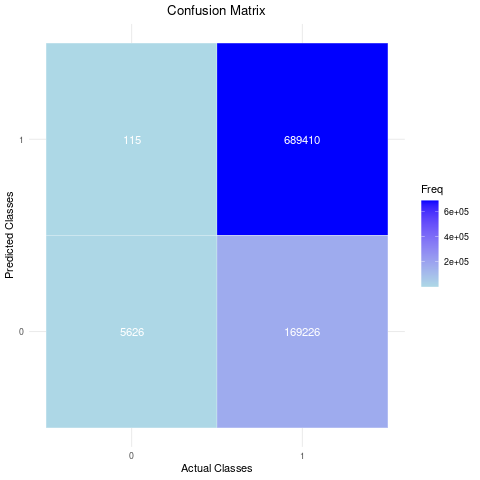

In [12]:
%%R
# Load required libraries
library(ggplot2)
library(caret)

# Generate the confusion matrix
cm <- confusionMatrix(factor(predicted_classes), factor(test_data$binaryDrivingMode))
cm_table <- as.data.frame(cm$table)

# Rename columns for better understanding
colnames(cm_table) <- c("Actual", "Predicted", "Freq")

# Create the colored confusion matrix plot
ggplot(cm_table, aes(x = Actual, y = Predicted, fill = Freq)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "lightblue", high = "blue", name = "Freq") +
  geom_text(aes(label = Freq), color = "white", size = 4) +
  labs(title = "Confusion Matrix", x = "Actual Classes", y = "Predicted Classes") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

Area under the curve: 0.593


Setting levels: control = 0, case = 1
Setting direction: controls < cases


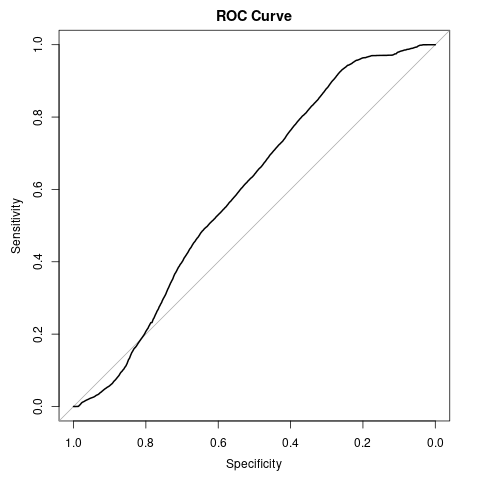

In [13]:
%%R

library(pROC)
roc_obj <- roc(test_data$binaryDrivingMode, predictions)
plot(roc_obj, main = "ROC Curve")
auc(roc_obj)

In [16]:
%%R
# Confusion Matrix values from the diagram
TP <- 689410 # True Positives
TN <- 5626 # True Negatives
FP <- 115 # False Positives
FN <- 169226 #False Negatives

#Calculating Accuracy
accuracy <- (TN + TP)/ (TP + TN + FP + FN)

#Calculating Recall
recall <- (TP/ TP + FN)

cat("Accuracy":accuracy, "\n")
cat("Recall":recall, "\n")

[1] "Accuracy: 0.804088956554837"
[1] "Recall: 169227"


In [8]:
%%R
# Calculate Precision
precision <- sum(predicted_classes == 1 & test_data$binaryDrivingMode == 1) / sum(predicted_classes == 1)

# Calculate Recall
recall <- sum(predicted_classes == 1 & test_data$binaryDrivingMode == 1) / sum(test_data$binaryDrivingMode == 1)

# Calculate F1-Score
f1_score <- 2 * (precision * recall) / (precision + recall)

# Print the results
print(paste("Precision:", precision))
print(paste("Recall:", recall))
print(paste("F1-Score:", f1_score))

Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'predicted_classes' not found


RInterpreterError: Failed to parse and evaluate line '# Calculate Precision\nprecision <- sum(predicted_classes == 1 & test_data$binaryDrivingMode == 1) / sum(predicted_classes == 1)\n\n# Calculate Recall\nrecall <- sum(predicted_classes == 1 & test_data$binaryDrivingMode == 1) / sum(test_data$binaryDrivingMode == 1)\n\n# Calculate F1-Score\nf1_score <- 2 * (precision * recall) / (precision + recall)\n\n# Print the results\nprint(paste("Precision:", precision))\nprint(paste("Recall:", recall))\nprint(paste("F1-Score:", f1_score))\n'.
R error message: "Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : \n  object 'predicted_classes' not found"